# Multi-head Attention

```python
import torch.nn.init as init
init.kaiming_normal_(weights, mode='fan_in', nonlinearity='relu')
init.xavier_normal_(input_,output_)

nn.softmax就是网络里的一部分，而f.softmax只是一个函数

所以区分一下torch.nn和torch.nn.functional

torch.randn(input_,output_) #(0,1)
torch.normal(mu,var,size=(input_,output_))
f.relu()
f.softmax()
f.linear()
```

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
X=torch.randn(128,64,512)  #batch, time, dimension
print(X.shape)
d_model=512
n_head=8

torch.Size([128, 64, 512])


In [7]:
#attention(Q,K,V)=softmax(QK^T/d**0.5)V
class multi_head_attention(nn.Module):  #需要继承nn.Module库
    def __init__(self,d_model,n_head)->None:
        super(multi_head_attention, self).__init__()
        self.d_model=d_model  #d_model is the length of word vector
        self.n_head=n_head
        
        self.w_q=nn.Linear(d_model,d_model,bias=False)
        self.w_k=nn.Linear(d_model,d_model,bias=False)
        self.w_v=nn.Linear(d_model,d_model,bias=False)
        self.fc_out=nn.Linear(d_model,d_model,bias=False)
        self.softmax=nn.Softmax(dim=-1)  #dim=-1只对最后一个维度进行操作
        
    def forward(self,x,mask=None):
        batch,time,dimension=x.shape
        n_d=self.d_model//self.n_head# 每个head的维度
        Q=self.w_q(x)
        K=self.w_k(x)
        V=self.w_v(x)
        #这里把n_head提上来，只对最后两个维度，也就是一个head的embed维度，和time长度进行处理
        Q=Q.view(batch,time,self.n_head,n_d).permute(0,2,1,3)
        K=K.view(batch,time,self.n_head,n_d).permute(0,2,1,3)
        V=V.view(batch,time,self.n_head,n_d).permute(0,2,1,3)
        
        
        A=Q@K.transpose(2,3)@Q/(n_d**0.5)
        if mask is not None:
            #triangle, up,上三角=1
            # mask=torch.triu(torch.ones(n_d,n_d),diagonal=1)
            mask = mask.masked_fill(mask == 1, float('-inf'))  #0*-inf=nan!
            # mask=mask*float('-inf')
            # print(f"mask:{mask}")
            A=A+mask
        A_hat=self.softmax(A)
        B=A_hat@V  
        B=B.permute(0,2,1,3).contiguous().view(batch,time,dimension)
        output=self.fc_out(B)
        return output
    
attention=multi_head_attention(d_model,n_head)
output=attention(X)
print(output,output.shape)
        

mask:tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[[-3.7301e-01,  1.8197e-01,  2.6710e-01,  ...,  1.7840e-01,
          -2.9911e-01,  5.2612e-01],
         [ 1.4155e-02,  1.4674e-01,  1.3217e-01,  ..., -3.9878e-02,
           6.7429e-02,  5.7636e-01],
         [-4.7279e-02, -3.3562e-02, -5.4954e-02,  ..., -1.0966e-01,
           1.8691e-01,  4.1482e-01],
         ...,
         [ 1.3496e-01,  9.8695e-02, -4.1887e-02,  ...,  1.6053e-01,
          -1.0137e-01,  1.0167e-01],
         [-5.5112e-02, -4.1049e-02,  1.0454e-01,  ...,  3.5729e-03,
           2.6214e-02,  1.3431e-01],
         [ 7.9412e-02,  1.7809e-01,  1.4203e-01,  ...,  7.9967e-03,
           8.5978e-02, -3.3748e-02]],

        [[ 5.5854e-02, -3.0863e-01, -3.3251e-01,  ..., -9.3577e-0

定义一个自定义的神经网络模块时，通常会继承 torch.nn.Module

nn.Module 是 PyTorch 中所有神经

可以通过torch.save()和torch.load()保存恢复模型
继承 nn.Module 后，你可以通过以下方式扩展它
* 定义自定义的网络结构（子模块）。
* 定义自定义的前向传播逻辑（forward 方法）。

这是 multi_head_attention 类的初始化方法，用于定义该模块的属性和子模块

`def __init__(self,) -> None:`

除了 self 参数外，你可以添加其他自定义的参数。这些参数可以用来配置类的行为、初始化特定的属性或子模块。

super().__init__() 是一个关键步骤，用于调用父类（nn.Module）的初始化方法：

`super(multi_head_attention, self).__init__()`

如果没有调用 super().__init__()，nn.Module 的一些功能（如参数管理、设备分配）将无法正常工作。


`requires_grad=True` 表示张量会参与自动求导，也就是这些参数会在反向传播时计算梯度，用于模型的优化

在你的 MultiHeadAttention 类中，nn.Linear 和 nn.Dropout 等层已经是 nn.Module 的子模块，它们的参数（如权重和偏置）会被 nn.Module 自动注册

这些参数已经默认设置了 requires_grad=True，所以在反向传播时会自动计算梯度
可以通过以下方式查看所有可训练参数
```python
mha = MultiHeadAttention(embed_dim=64, num_heads=8)
for name, param in mha.named_parameters():
    print(name, param.shape, param.requires_grad)
```

默认情况下，nn.Module 的参数已经启用了 requires_grad=True
* 你不需要手动设置 requires_grad=True。
* 所有 nn.Linear 和其他可训练模块的参数都会自动被优化。

手动创建参数时需要设置 `requires_grad=True`，如果你手动定义某些权重参数，而不是通过 nn.Linear 或其他层生成，需要显式地设置 requires_grad=True。

冻结参数时需要设置 requires_grad=False


* PyTorch 的操作会自动识别批次维度并只对最后两个维度进行矩阵乘法！！


## GPT的multi-head Attention

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        初始化多头注意力模块。
        
        Args:
        - embed_dim (int): 输入的嵌入维度（d_model）。
        - num_heads (int): 注意力头的数量。
        - dropout (float): Dropout 的比例。
        """
        super(MultiHeadAttention, self).__init__()
        
        # 验证 embed_dim 是否可以被 num_heads 整除
        assert embed_dim % num_heads == 0, "embed_dim 必须能够整除 num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # 每个头的维度 d_k
        
        # 定义 Q, K, V 的权重
        self.W_Q = nn.Linear(embed_dim, embed_dim)  # (embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)  # (embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)  # (embed_dim, embed_dim)
        
        # 输出权重
        self.fc_out = nn.Linear(embed_dim, embed_dim)  # (embed_dim, embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        前向传播。
        
        Args:
        - x (Tensor): 输入张量，形状为 (batch_size, seq_length, embed_dim)。
        
        Returns:
        - out (Tensor): 输出张量，形状为 (batch_size, seq_length, embed_dim)。
        - attention (Tensor): 注意力矩阵，形状为 (batch_size, num_heads, seq_length, seq_length)。
        """
        batch_size, seq_length, embed_dim = x.size()
        
        # 计算 Q, K, V
        Q = self.W_Q(x)  # (batch_size, seq_length, embed_dim)
        K = self.W_K(x)  # (batch_size, seq_length, embed_dim)
        V = self.W_V(x)  # (batch_size, seq_length, embed_dim)
        
        # 拆分为多头
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_length, head_dim)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_length, head_dim)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_length, head_dim)
        
        # 点积注意力计算
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_length, seq_length)
        attention = torch.softmax(attention_scores, dim=-1)  # 归一化
        attention = self.dropout(attention)  # Dropout
        
        # 加权 V
        out = torch.matmul(attention, V)  # (batch_size, num_heads, seq_length, head_dim)
        
        # 合并多头
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, embed_dim)  # (batch_size, seq_length, embed_dim)
        
        # 输出线性变换
        out = self.fc_out(out)  # (batch_size, seq_length, embed_dim)
        
        return out, attention

# Encoder Embedding

在 Transformer 中，由于模型是完全基于注意力机制的，没有像 RNN 那样的顺序依赖，因此模型无法直接感知输入序列中每个元素的位置信息
为了让模型能够感知输入序列中词或子词的顺序信息，Transformer 引入了 位置嵌入（Positional Embedding）

$$
PE_{pos, 2i} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) \\ 
PE_{pos, 2i+1} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

In [6]:
class TokenEmbedding(nn.Embedding):
    def __init__(self,vocab_size,d_model):
        super(TokenEmbedding,self).__init__(vocab_size,d_model,padding_idx=1)

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self,d_model,maxlen,device):
        super(PositionalEmbedding,self).__init__()
        
        self.encoding=torch.zeros(maxlen,d_model,device,requires_grad=False)
        #generate 0-maxlen
        pos=torch.arange(0,maxlen,device)
        pos=pos.float().unsqueeze(1) 
        
        _2i=torch.arange(0,d_model,2,device)   # [0, 2, 4, ..., d_model-2],生成偶数维度的索引,因为2i还是2i+1都是只用偶数idx
        self.encoding[:,0::2]=torch.sin(pos/(10000**(_2i/d_model))) #broadcast dimension is d_model/2
        self.encoding[:,1::2]=torch.cos(pos/(10000**(_2i/d_model))) #will auto match!
        
        
    def forward(self,x):
        seq_len=x.shape[1]
        return self.encoding[:seq_len,:] 

### Layer Norm
一个样本内的feature维度 进行归一化,对 RNN 效果显著，能处理变长序列数据
可以减小对显存的需求,在feature(channel维度)

### Batch Norm 
需要加载很多,一个批次内的每个特征维度 进行归一化, 图像处理用的比较多

### Group Norm
和Batch Norm很类似

Batch Normalization 的处理对象是对一批样本， Layer Normalization 的处理对象是单个样本。
Batch Normalization 是对这批样本的同一维度特征做归一化， Layer Normalization 是对这单个样本的所有维度特征做归一化

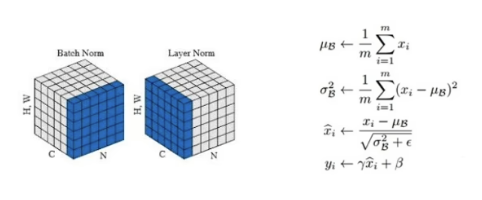

B,L,D 输入
归一化后引入两个可学习参数 𝛾和 𝛽：都是D的维度,允许模型恢复任意线性变换，增加表达能力。

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self,d_model,eps=1e-10):
        super(LayerNorm,self).__init__()
        self.gamma=nn.Parameter(torch.ones(d_model)) #gamma initialize to 1
        self.beta=nn.Parameter(torch.zeros(d_model)) #beta initialize to 0
        self.eps=eps
        
    #x input (B,L,D) batch length feature_dimension
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True) #dim=-1表示按照最后一个维度D
        var=x.var(dim=-1,unbiased=False,keepdim=True)
        out=(x-mean)/torch.sqrt(var**2+self.eps)
        out=self.gamma*out+self.beta
        return out
    

### FFN
Position-Wise Fully Connected Feed-Forward Network
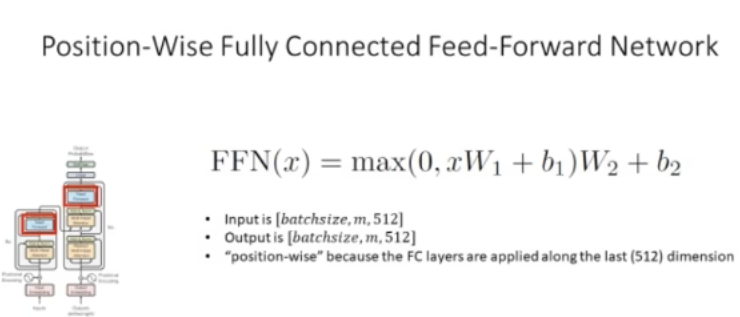

In [ ]:
class PostionalFeedForward(nn.Module):
    def __init__(self,d_model,hidden,dropout=0.1):
        self.fc1=nn.Linear(d_model,hidden)
        self.fc2=nn.Linear(hidden,d_model)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        x=self.fc1(x)
        x=F.ReLU(x)
        x=self.dropout(x) 
        x=self.fc2(x)
        return x

# GPT encoding

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: 嵌入的维度（词向量维度）
        max_len: 序列的最大长度
        """
        super(PositionalEncoding, self).__init__()
        
        # 创建一个 max_len x d_model 的矩阵，保存位置编码
        position = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # [d_model//2]
        
        # 偶数维度使用 sin，奇数维度使用 cos
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
        
        # 增加 batch 维度 (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        
        # 将位置编码注册为模型的 buffer，防止被更新
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: 输入张量，形状为 [batch_size, seq_len, d_model]
        """
        # 截取与输入序列长度匹配的部分，并加到输入上
        x = x + self.pe[:, :x.size(1), :]
        return x


In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self,vocab_size,d_model,max_len,dropout,device):
        super(TransformerEmbedding,self).__init__()
        self.tok_emb=TokenEmbedding(vocab_size,d_model,device)
        self.pos_emb=PositionalEmbedding(d_model,max_len,dropout,device)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        tok_emb=self.tok_emb(x)
        pos_emb=self.pos_emb(x)
        return self.dropout(tok_emb+pos_emb)
        

# Encoder Layer

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self,d_model,ffn_hidden,n_head,dropout)->None:
        super(EncoderLayer,self).__init__()
        self.attention=multi_head_attention(d_model,n_head)
        self.norm1=LayerNorm(d_model)
        self.drop1=nn.Dropout(dropout)
        
        self.ffn=PostionalFeedForward(d_model,ffn_hidden,dropout)
        self.norm2=LayerNorm(d_model)
        self.drop2=nn.Dropout(dropout)
        
    def forward(self,x,mask=None):
        _x=x
        x=self.attention(x,mask)
        x=self.drop1(x)
        x=self.norm1(x+_x)
        _x=x
        
        x=self.ffn(x)
        x=self.drop2(x)
        x=self.norm2(x+_x)
         
        return x

# Decoder Layer

### cross attention

In [ ]:
import torch
import torch.nn as nn

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, n_head):
        """
        d_model: 嵌入维度（word vector 的长度）
        n_head: 注意力头的数量
        """
        super(MultiHeadCrossAttention, self).__init__()
        self.d_model = d_model
        self.n_head = n_head

        # 线性变换：为 Q, K, V 引入头
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

        # 输出层
        self.fc_out = nn.Linear(d_model, d_model, bias=False)
        self.softmax = nn.Softmax(dim=-1)  # 归一化在最后一维

    def forward(self, Q, K, V, mask=None):
        """
        Q: 查询向量，形状 [batch_size, seq_len_q, d_model]
        K: 键向量，形状 [batch_size, seq_len_k, d_model]
        V: 值向量，形状 [batch_size, seq_len_k, d_model]
        mask: 掩码矩阵，形状 [batch_size, seq_len_q, seq_len_k]
        """
        batch_size = Q.shape[0]
        seq_len_q = Q.shape[1]
        seq_len_k = K.shape[1]
        n_d = self.d_model // self.n_head  # 每个头的嵌入维度

        # 线性变换：计算 Q, K, V
        Q = self.w_q(Q)  # [batch_size, seq_len_q, d_model]
        K = self.w_k(K)  # [batch_size, seq_len_k, d_model]
        V = self.w_v(V)  # [batch_size, seq_len_k, d_model]

        # 多头拆分：reshape + permute
        Q = Q.view(batch_size, seq_len_q, self.n_head, n_d).permute(0, 2, 1, 3)  # [batch_size, n_head, seq_len_q, n_d]
        K = K.view(batch_size, seq_len_k, self.n_head, n_d).permute(0, 2, 1, 3)  # [batch_size, n_head, seq_len_k, n_d]
        V = V.view(batch_size, seq_len_k, self.n_head, n_d).permute(0, 2, 1, 3)  # [batch_size, n_head, seq_len_k, n_d]

        # 注意力分数计算
        attention_scores = Q @ K.transpose(-2, -1) / (n_d ** 0.5)  # [batch_size, n_head, seq_len_q, seq_len_k]

        # 应用掩码（如果提供）
        if mask is not None:
            # mask: [batch_size, seq_len_q, seq_len_k]
            attention_scores = attention_scores.masked_fill(mask == 1, float('-inf'))

        # 计算注意力权重
        attention_weights = self.softmax(attention_scores)  # [batch_size, n_head, seq_len_q, seq_len_k]

        # 注意力值计算
        attention_output = attention_weights @ V  # [batch_size, n_head, seq_len_q, n_d]

        # 恢复多头合并的形状
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous()  # [batch_size, seq_len_q, n_head, n_d]
        attention_output = attention_output.view(batch_size, seq_len_q, self.d_model)  # [batch_size, seq_len_q, d_model]

        # 全连接层输出
        output = self.fc_out(attention_output)  # [batch_size, seq_len_q, d_model]

        return output


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,d_model,ffn_hidden,n_head,dropout):
        super(DecoderLayer,self).__init__()
        self.attention=multi_head_attention(d_model,n_head)
        self.norm1=LayerNorm(d_model)
        self.drop1=nn.Dropout(dropout)
        
        #cross attention
        self.cross_attention=MultiHeadCrossAttention(d_model,n_head)     
        self.norm2=LayerNorm(d_model)
        self.drop2=nn.Dropout(dropout)
        
        self.ffn=PostionalFeedForward(d_model,ffn_hidden,dropout)
        self.norm3=LayerNorm(d_model)
        self.drop3=nn.Dropout(dropout)
        
    #t_mask is timer mask
    #s_make the length mask?
    def forward(self,dec,enc,t_mask,s_mask):
        _x=dec
        x=self.attention(dec,t_mask)#下三角掩码,不看未来的seq
        
        x=self.drop1(x)
        x=self.norm1(x+_x)
        
        #cross attention
        if enc is not None:
            _x=x
            #q from decoder, k,v from encoder!
            x=self.cross_attention(x,enc,enc,s_mask) #s_mask to align word vector
            
            x=self.drop2(x)
            x=self.norm2(x+_x)
            
        _x=x
        x=self.ffn(x)
        x=self.drop3(x)
        x=self.norm3(x+_x)
        
        return x
           

In [ ]:
class Encoder(nn.Module):
    def __init__(self, enc_voc_size,max_len,d_model,ffn_hidden,n_head,n_layer,dropout,device):
        super(Encoder,self).__init__()
        
        self.embedding=TransformerEmbedding(enc_voc_size,d_model,max_len,dropout,device)
        self.layers=nn.Modulelist(
            [EncoderLayer(d_model,ffn_hidden,n_head,dropout) for _ in range(n_layer)] 
        )
    
    def forward(self,x,s_mask):
        x=self.embedding(x)
        for layer in self.layers:
            x=layer(x,s_mask)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size,max_len,d_model,ffn_hidden,n_head,n_layer,dropout,device):
        super(Decoder,self).__init__()
        
        self.embedding=TransformerEmbedding(dec_voc_size,d_model,max_len,dropout,device)
        self.layers=nn.Modulelist(
            [DecoderLayer(d_model,ffn_hidden,n_head,dropout) for _ in range(n_layer)] 
        )
        self.fc=nn.Linear(d_model,dec_voc_size)
        
    
    def forward(self,dec,enc,t_mask,s_mask):
        dec=self.embedding(dec)
        for layer in self.layers:
            dec=layer(dec,enc,t_mask,s_mask)
        dec=self.fc(dec)
        return dec

# Mask才是Transformer的真细节

In [ ]:
class Transformer(nn.Module):
    def __init__(self,src_pad_idx,trg_pad_idx,enc_voc_size,dec_voc_size,maxlen,d_model,n_head,ffn_hidden,n_layer,dropout,device):
        super(Transformer,self).__init__()
        
        self.encoder=Encoder(enc_voc_size,maxlen,d_model,ffn_hidden,n_head,n_layer,dropout,device)
        self.decoder=Decoder(dec_voc_size,maxlen,d_model,ffn_hidden,n_head,n_layer,dropout,device)
        
        self.src_pad_idx=src_pad_idx
        self.trg_pad_idx=trg_pad_idx
        self.device=device
     
    def make_pad_mask(self,q,k,pad_idx_q,pad_idx_k):
        len_q,len_k=q.size(1),k.size(1)
        #(Batch,Time,len_q,len_k)
        q=q.ne(pad_idx_q).unsqueeze(1).unsqueeze(3)
        q=q.repeat(1,1,1,len_k)
        k=k.ne(pad_idx_k).unsqueeze(1).unsqueeze(2)
        k=k.repeat(1,1,len_q,1)
        mask=q&k
        return mask
       
    #causal mask 上三角掩码
    def make_causual_mask(self,q,k):
        len_q,len_k=q.size(1),k.size(1)
        mask=torch.tril(torch.ones((len_q,len_k)).type(torch.BoolTensor).to(self.device))
        return mask
    
    def forward(self,src,trg):
        src_mask=self.make_pad_mask(src,src,self.src_pad_idx,self.src_pad_idx)
        trg_mask=self.make_pad_mask(trg,trg,self.trg_pad_idx,self.trg_pad_idx)*self.make_causual_mask(trg,trg)
        
        src_trg_mask=self.make_pad_mask(trg,src,self.trg_pad_idx,self.src_pad_idx) 
        enc=self.encoder(src,src_mask)
        output=self.decoder(trg,enc,trg_mask,src_trg_mask) 

两个 pad_idx 参数，分别用于源序列（source sequence）和目标序列（target sequence）。它们的主要作用是处理填充符（padding token，通常是 <PAD>）的位置，以确保模型在计算中正确忽略这些无效的填充部分

在多头注意力中，源序列的填充部分不应该被注意力机制考虑，因为这些填充符并不携带有意义的信息。
在解码器的交叉注意力层和目标序列的自注意力层中，目标序列的填充部分同样不应该被注意力机制计算。

句子1：["I", "like", "cats", "<PAD>", "<PAD>"]
句子2：["You", "love", "<PAD>", "<PAD>", "<PAD>"]
句子3：["We", "play", "football", "everyday"]

{
  "<PAD>": 0,
  "I": 1,
  "like": 2,
  "cats": 3,
  "You": 4,
  "love": 5,
  "We": 6,
  "play": 7,
  "football": 8,
  "everyday": 9
}
```python
import torch

# 输入张量
batch = torch.tensor([
    [1, 2, 3, 0, 0],  # 句子1
    [4, 5, 0, 0, 0],  # 句子2
    [6, 7, 8, 9, 0]   # 句子3
])  # [batch_size, seq_len]

# 定义 pad_idx
pad_idx = 0

# 生成填充掩码
mask = (batch == pad_idx)  # [batch_size, seq_len]
print(mask)
```



# GPT 调用 nn.Transformer

In [ ]:
import torch
import torch.nn as nn

# 定义模型参数
d_model = 512       # 嵌入维度
nhead = 8           # 注意力头数
num_encoder_layers = 6  # 编码器层数
num_decoder_layers = 6  # 解码器层数
dim_feedforward = 2048  # 前馈网络的维度
dropout = 0.1           # Dropout 比例

# 实例化 Transformer 模型
transformer = nn.Transformer(
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

# 输入示例
src = torch.rand((10, 32, d_model))  # 源序列：[seq_len_src, batch_size, d_model]
tgt = torch.rand((20, 32, d_model))  # 目标序列：[seq_len_tgt, batch_size, d_model]

# 上三角掩码，用于目标序列
tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0))

# 前向传播
output = transformer(src, tgt, tgt_mask=tgt_mask)
print("Output shape:", output.shape)  # [seq_len_tgt, batch_size, d_model]


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        src_embedded = self.src_embedding(src)  # [seq_len_src, batch_size, d_model]
        tgt_embedded = self.tgt_embedding(tgt)  # [seq_len_tgt, batch_size, d_model]
        output = self.transformer(
            src_embedded,
            tgt_embedded,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.fc_out(output)

# 示例训练
src_vocab_size = 10000
tgt_vocab_size = 10000
model = TransformerModel(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1
)

# 假设输入
src = torch.randint(0, src_vocab_size, (20, 32))  # [seq_len_src, batch_size]
tgt = torch.randint(0, tgt_vocab_size, (20, 32))  # [seq_len_tgt, batch_size]

# 生成掩码
tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0))

# 前向传播
output = model(src, tgt, tgt_mask=tgt_mask)
print("Output shape:", output.shape)  # [seq_len_tgt, batch_size, tgt_vocab_size]
